In [2]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.io import imread
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
from skimage.io import imread
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix


2025-05-23 01:24:20.693537: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 01:24:20.704723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 01:24:20.786204: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 01:24:20.860321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747959860.922177   54034 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747959860.93

# Visualization of the new dataset generated from the original dataset (images)

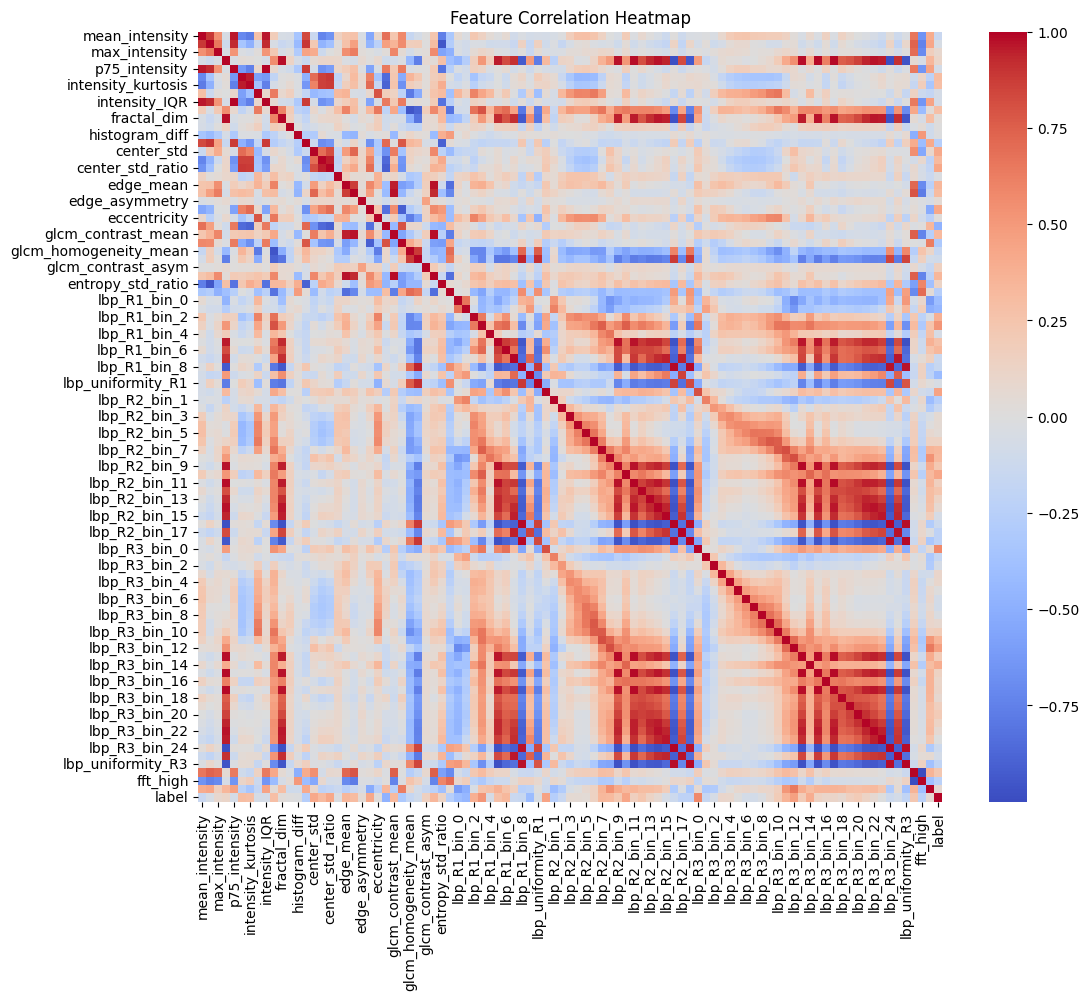

🔍 Dropped 24 highly correlated features.


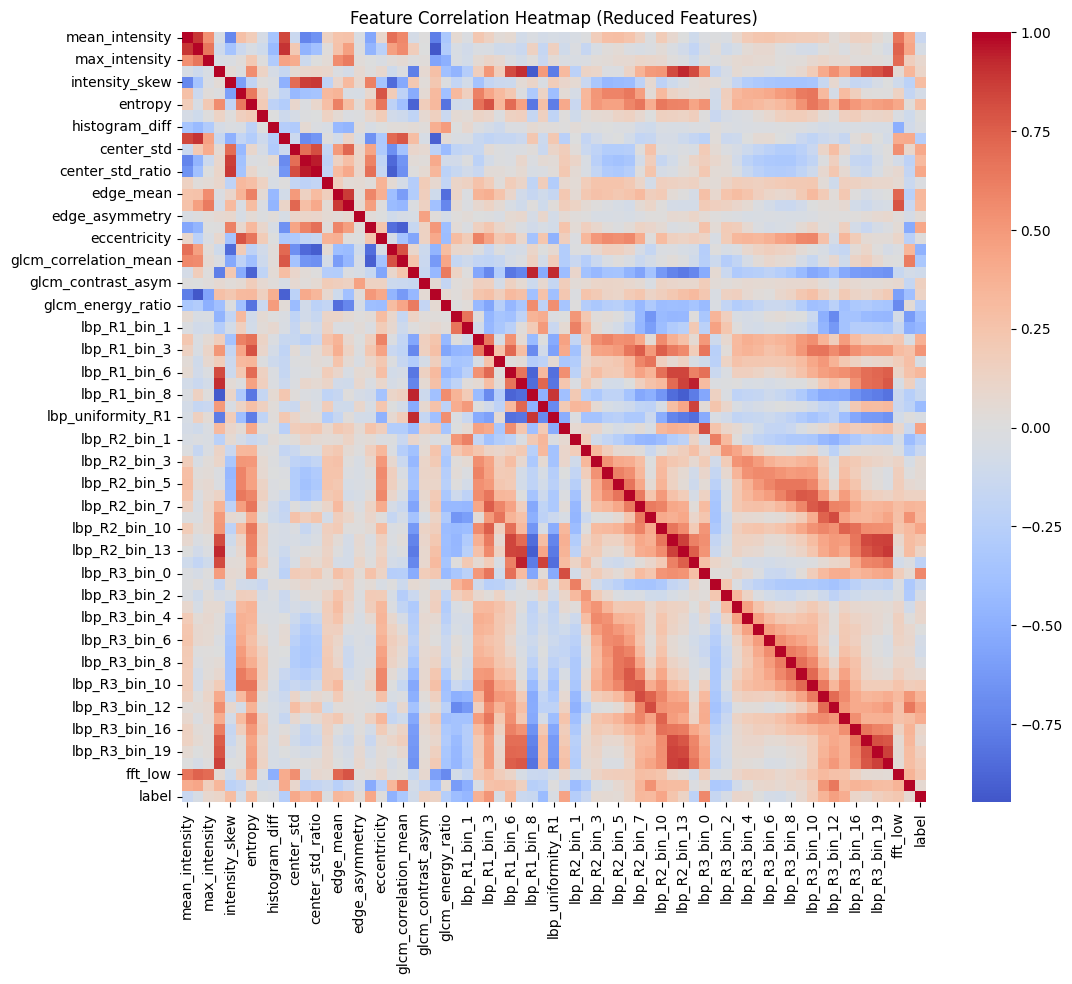

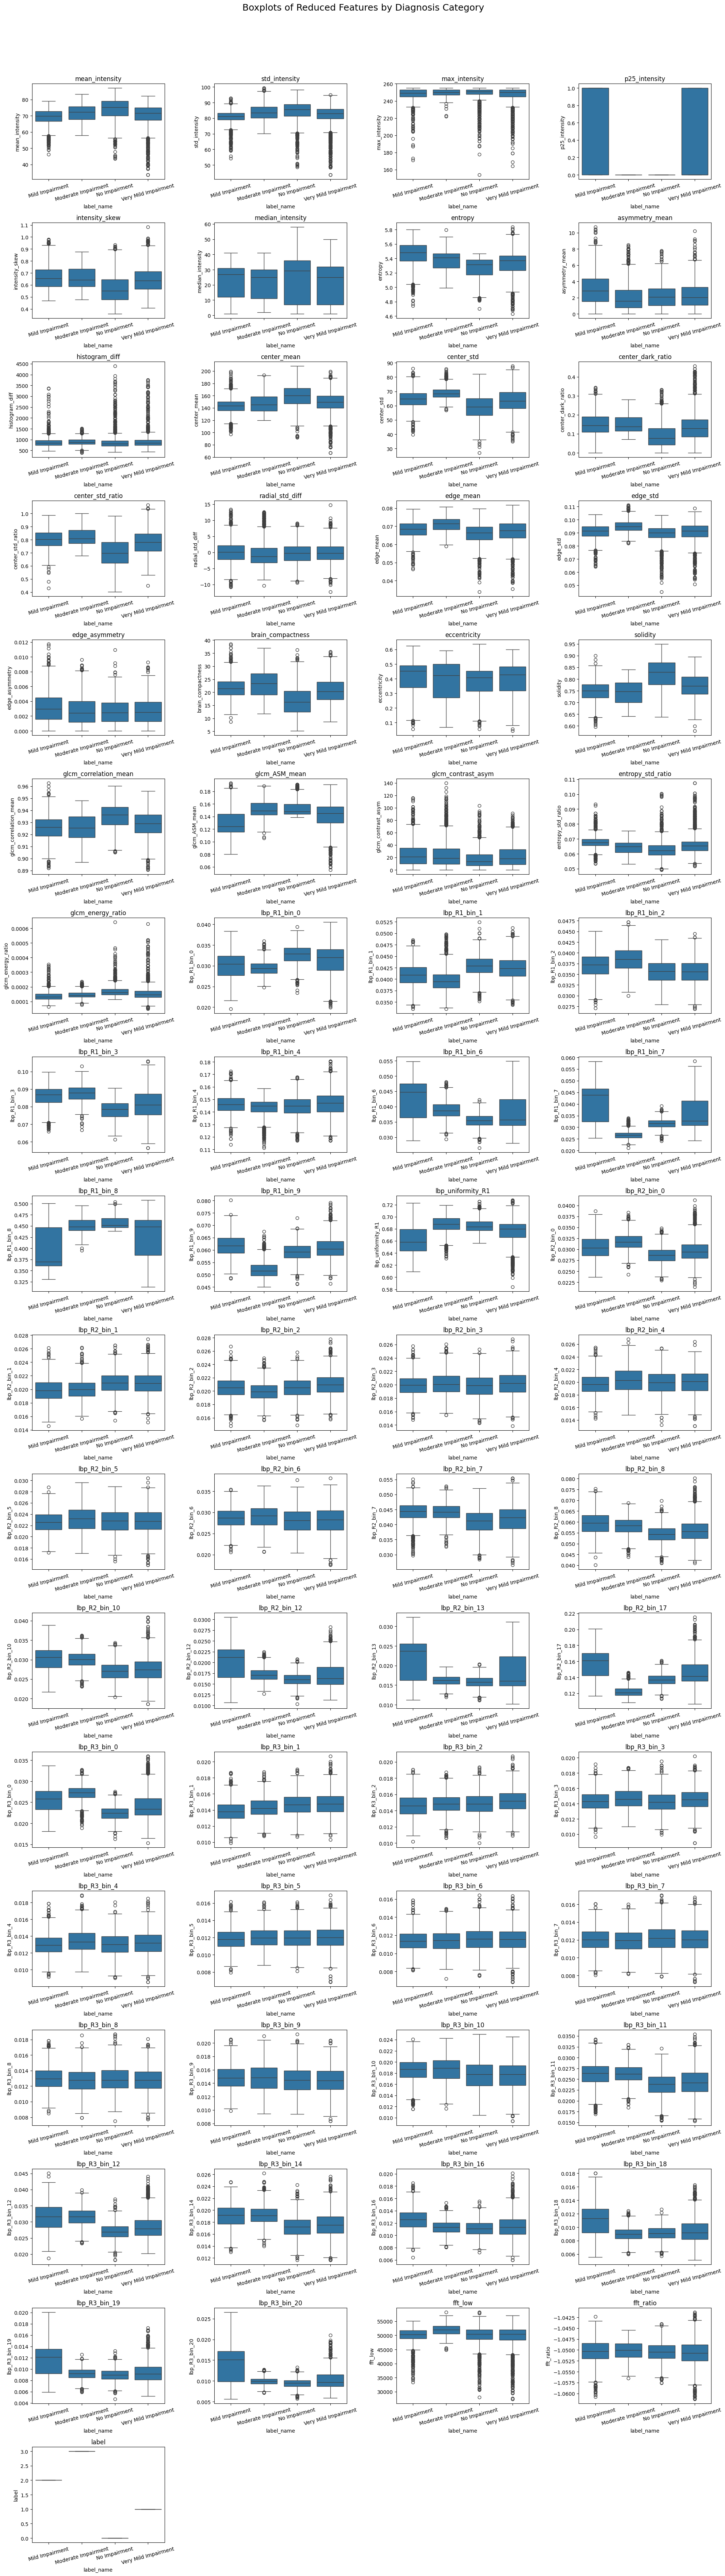

In [ ]:
# --- Load Data ---
df = pd.read_csv("train_features.csv")

# --- Label Mapping ---
label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}
df['label_name'] = df['label'].map(label_map)

# --- Feature Selection (drop labels) ---
numeric_features = df.drop(columns=["label_name"])

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Remove Highly Correlated Features ---
corr_matrix = numeric_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = numeric_features.drop(columns=to_drop)

print(f"🔍 Dropped {len(to_drop)} highly correlated features.")

# --- Correlation Heatmap (Reduced Set) ---
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Reduced Features)")
plt.show()

# --- Boxplots for All Reduced Features ---
df_reduced = reduced_features.copy()
df_reduced['label_name'] = df['label_name']

n_features = len(reduced_features.columns)
cols = 4  
rows = (n_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(reduced_features.columns):
    sns.boxplot(x='label_name', y=feature, data=df_reduced, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots of Reduced Features by Diagnosis Category", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

🎯 Final selected features (68):
['lbp_R1_bin_8', 'fft_high', 'lbp_R3_bin_15', 'glcm_correlation_mean', 'intensity_IQR', 'lbp_R2_bin_10', 'intensity_skew', 'lbp_R2_bin_3', 'asymmetry_mean', 'lbp_R3_bin_11', 'lbp_uniformity_R1', 'lbp_R1_bin_0', 'center_std', 'brain_compactness', 'lbp_R3_bin_2', 'max_intensity', 'fft_ratio', 'lbp_R3_bin_1', 'lbp_R2_bin_4', 'edge_mean', 'edge_asymmetry', 'center_std_ratio', 'lbp_R3_bin_8', 'lbp_R2_bin_2', 'lbp_R1_bin_6', 'lbp_R1_bin_3', 'eccentricity', 'lbp_R3_bin_18', 'lbp_R2_bin_1', 'lbp_R3_bin_20', 'lbp_R2_bin_8', 'lbp_R2_bin_17', 'radial_std_diff', 'lbp_R3_bin_4', 'std_intensity', 'lbp_R2_bin_7', 'lbp_R3_bin_3', 'lbp_R3_bin_21', 'lbp_R2_bin_12', 'glcm_energy_ratio', 'center_mean', 'edge_std', 'glcm_contrast_asym', 'lbp_R3_bin_9', 'glcm_homogeneity_mean', 'entropy_std_ratio', 'lbp_R3_bin_0', 'lbp_R2_bin_5', 'lbp_R3_bin_5', 'lbp_R1_bin_2', 'lbp_R3_bin_12', 'lbp_R1_bin_9', 'solidity', 'center_dark_ratio', 'lbp_R3_bin_14', 'lbp_R3_bin_6', 'lbp_R1_bin_1', '

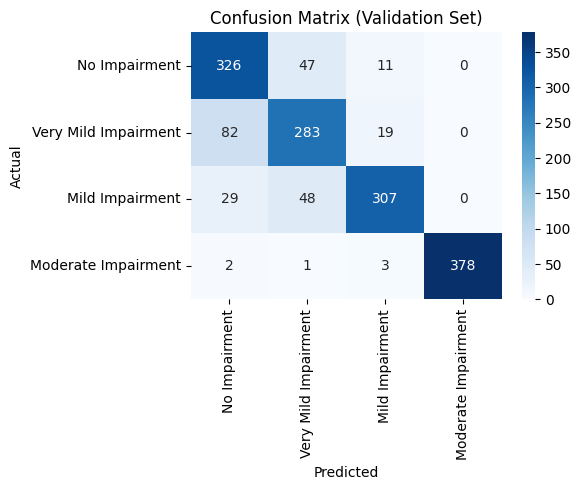


🧪 Test Set Performance
Accuracy: 0.6849100860046912
Balanced Accuracy: 0.4567993066640064
                      precision    recall  f1-score   support

       No Impairment     0.7522    0.8156    0.7826       640
Very Mild Impairment     0.6025    0.6429    0.6220       448
     Mild Impairment     0.6226    0.3687    0.4632       179
 Moderate Impairment     0.0000    0.0000    0.0000        12

            accuracy                         0.6849      1279
           macro avg     0.4943    0.4568    0.4669      1279
        weighted avg     0.6746    0.6849    0.6743      1279



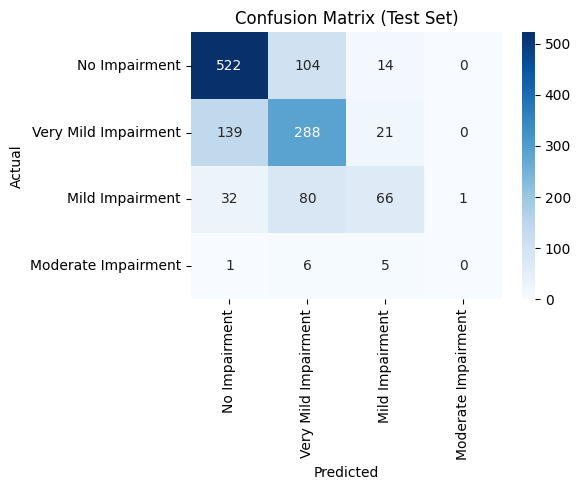

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#  Load and filter dataset (3 classes only) 
df = pd.read_csv("train_features.csv")
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

#  Step 1: Feature Selection 
f_scores, pvals = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores, "p_value": pvals})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.sort_values(by="F_score", ascending=False).head(120)["Feature"])
top_mi = set(mi_df.sort_values(by="MI_Score", ascending=False).head(120)["Feature"])
core_features = list(top_f & top_mi)

#  Step 2: Remove Highly Correlated Features 
corr_matrix = X_all[core_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
core_decorrelated = [f for f in core_features if f not in to_drop]

final_features = core_decorrelated

print(f"🎯 Final selected features ({len(final_features)}):\n{final_features}")

#  Load Validation and Test sets 
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

# Define labels
y_val = val_df["label"]
y_test = test_df["label"]

# Extract features
X_train = X_all[final_features]
X_val = val_df[final_features]
X_test = test_df[final_features]

# Grid Search for Best Hyperparameters
# param_grid = {
#     'max_depth': [8, 12, 16],
#     'learning_rate': [0.01, 0.03, 0.05],
#     'n_estimators': [300],
#     'class_weight': ['balanced']
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# lgbm = LGBMClassifier(random_state=42)
# 
# grid = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='balanced_accuracy',
#     n_jobs=-1,
#     verbose=1
# )
# 
# grid.fit(X_train, y_all)
# 
# print(" Best Parameters:", grid.best_params_)
# print("Best CV Balanced Accuracy:", grid.best_score_)

#  Step 4: Train Final Model with Best Parameters 
clf = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    scale_pos_weight=None,
    eval_metric='mlogloss',
    use_label_encoder=False,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_all)

#  Evaluation Utility 
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment",
    3: "Moderate Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

#  Step 5: Evaluate on Validation and Test Sets 
evaluate_set(X_val, y_val, "Validation Set")
evaluate_set(X_test, y_test, "Test Set")


Note: you may need to restart the kernel to use updated packages.
🎯 Final selected features (63):
['glcm_correlation_mean', 'lbp_R3_bin_10', 'lbp_R3_bin_3', 'fft_high', 'lbp_R2_bin_8', 'eccentricity', 'lbp_R3_bin_17', 'center_std_ratio', 'edge_mean', 'solidity', 'lbp_R1_bin_6', 'intensity_kurtosis', 'lbp_R1_bin_2', 'intensity_IQR', 'lbp_R1_bin_3', 'lbp_R1_bin_7', 'lbp_R2_bin_6', 'brain_compactness', 'asymmetry_mean', 'median_intensity', 'lbp_R3_bin_1', 'lbp_R3_bin_7', 'lbp_R2_bin_17', 'max_intensity', 'lbp_R2_bin_13', 'lbp_R2_bin_0', 'lbp_R2_bin_7', 'lbp_R3_bin_19', 'edge_std', 'glcm_homogeneity_mean', 'lbp_R3_bin_2', 'lbp_R3_bin_8', 'lbp_R3_bin_4', 'lbp_R1_bin_9', 'lbp_R2_bin_1', 'lbp_R3_bin_18', 'glcm_ASM_mean', 'glcm_contrast_asym', 'center_std', 'lbp_R3_bin_16', 'lbp_R3_bin_20', 'lbp_R2_bin_10', 'lbp_R2_bin_12', 'lbp_R2_bin_4', 'lbp_R3_bin_9', 'histogram_diff', 'lbp_R1_bin_4', 'lbp_R3_bin_0', 'center_dark_ratio', 'lbp_R3_bin_12', 'lbp_R2_bin_3', 'lbp_R3_bin_6', 'std_intensity', 'lb

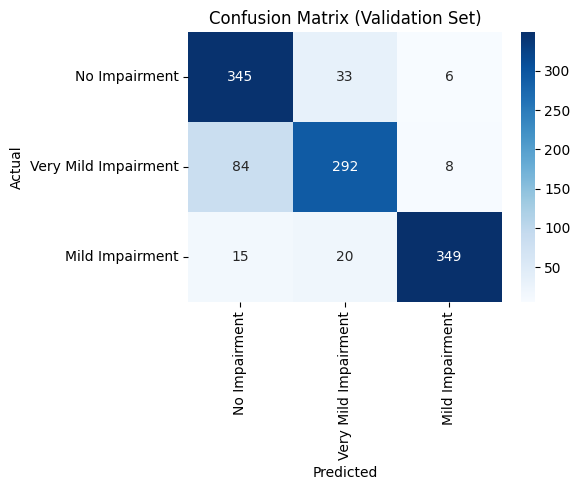


🧪 Test Set Performance
Accuracy: 0.7490134175217048
Balanced Accuracy: 0.6884373337323756
                      precision    recall  f1-score   support

       No Impairment     0.7956    0.8516    0.8226       640
Very Mild Impairment     0.6927    0.6942    0.6934       448
     Mild Impairment     0.6992    0.5196    0.5962       179

            accuracy                         0.7490      1267
           macro avg     0.7292    0.6884    0.7041      1267
        weighted avg     0.7456    0.7490    0.7450      1267



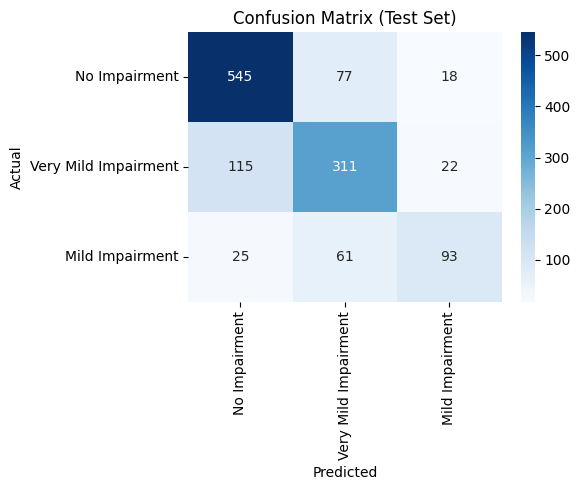

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
%pip install lightgbm
from lightgbm import LGBMClassifier

#  Load and filter dataset (3 classes only) 
df = pd.read_csv("train_features.csv")
df = df[df["label"] < 3]  # Keep only classes 0, 1, 2
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

#  Optional: Feature Engineering (custom interactions) 
# Example interaction features (add more if desired)
X_all["texture_richness"] = X_all["glcm_contrast_mean"] * X_all["entropy"]
X_all["center_std_ratio"] = X_all["center_std"] / (X_all["std_intensity"] + 1e-6)

#  Step 1: Feature Selection 
f_scores, pvals = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores, "p_value": pvals})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.sort_values(by="F_score", ascending=False).head(100)["Feature"])
top_mi = set(mi_df.sort_values(by="MI_Score", ascending=False).head(100)["Feature"])
core_features = list(top_f & top_mi)

#  Step 2: Remove Highly Correlated Features 
corr_matrix = X_all[core_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
core_decorrelated = [f for f in core_features if f not in to_drop]

final_features = core_decorrelated 

print(f"🎯 Final selected features ({len(final_features)}):\n{final_features}")

#  Load Validation and Test sets 
val_df = pd.read_csv("val_features.csv")
val_df = val_df[val_df["label"] < 3]
test_df = pd.read_csv("test_features.csv")
test_df = test_df[test_df["label"] < 3]

# Recompute custom features for val/test
for dataset in [val_df, test_df]:
    dataset["texture_richness"] = dataset["glcm_contrast_mean"] * dataset["entropy"]
    dataset["center_std_ratio"] = dataset["center_std"] / (dataset["std_intensity"] + 1e-6)

# Define labels
y_val = val_df["label"]
y_test = test_df["label"]

# Extract features
X_train = X_all[final_features]
X_val = val_df[final_features]
X_test = test_df[final_features]

#  Train LightGBM Model with Class Balancing 
clf = LGBMClassifier(
    n_estimators=300,
    max_depth=16,
    class_weight="balanced",  # Or pass dict {0:1, 1:1.5, 2:3}
    learning_rate=0.05,
    random_state=42
)
clf.fit(X_train, y_all)

#  Evaluation Utility 
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

#  Evaluate on Validation and Test 
evaluate_set(X_val, y_val, "Validation Set")
evaluate_set(X_test, y_test, "Test Set")
